In [277]:
import numpy as np
np.random.seed(4)
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

#
# Funciones auxiliares
#
def graficar_predicciones(real, prediccion):
    plt.plot(real[0:len(prediccion)],color='red', label='Valor real de la acción')
    plt.plot(prediccion, color='blue', label='Predicción de la acción')
    plt.ylim(1.1 * np.min(prediccion)/2, 1.1 * np.max(prediccion))
    plt.xlabel('Tiempo')
    plt.ylabel('Valor de la acción')
    plt.legend()
    plt.show()

#
# Lectura de los datos
#
dataset = pd.read_csv('AAPL_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head()
#dataset.size

Open   High    Low  Close     Volume  Name
Date                                                   
2006-01-03  10.34  10.68  10.32  10.68  201853036  AAPL
2006-01-04  10.73  10.85  10.64  10.71  155225609  AAPL
2006-01-05  10.69  10.70  10.54  10.63  112396081  AAPL
2006-01-06  10.75  10.96  10.65  10.90  176139334  AAPL
2006-01-09  10.96  11.03  10.82  10.86  168861224  AAPL

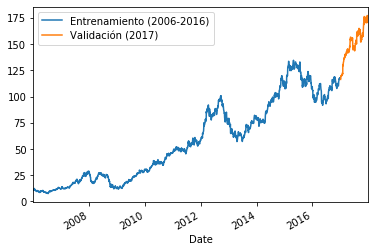

In [278]:
#
# Sets de entrenamiento y validación 
# La LSTM se entrenará con datos de 2016 hacia atrás. La validación se hará con datos de 2017 en adelante.
# En ambos casos sólo se usará el valor más alto de la acción para cada día
#
set_entrenamiento = dataset[:'2016'].iloc[:,1:2]
set_validacion = dataset['2017':].iloc[:,1:2]

set_entrenamiento['High'].plot(legend=True)
set_validacion['High'].plot(legend=True)
plt.legend(['Entrenamiento (2006-2016)', 'Validación (2017)'])
plt.show()

In [279]:
# Normalización del set de entrenamiento
sc = MinMaxScaler(feature_range=(0,1))
set_entrenamiento_escalado = sc.fit_transform(set_entrenamiento)


In [280]:
# La red LSTM tendrá como entrada "time_step" datos consecutivos, y como salida 1 dato (la predicción a
# partir de esos "time_step" datos). Se conformará de esta forma el set de entrenamiento
time_step = 60
X_train = []
Y_train = []
m = len(set_entrenamiento_escalado)

for i in range(time_step,m):
    # X: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
    #print(set_entrenamiento_escalado[i-time_step:i,0])
    X_train.append(set_entrenamiento_escalado[i-time_step:i,0])

    # Y: el siguiente dato
    Y_train.append(set_entrenamiento_escalado[i,0])
X_train, Y_train = np.array(X_train), np.array(Y_train)

In [281]:
# Reshape X_train para que se ajuste al modelo en Keras
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


In [ ]:
#
# Red LSTM
#
dim_entrada = (X_train.shape[1],1)
dim_salida = 1
na = 180

modelo = Sequential()
"""
modelo.add(LSTM(units=na, input_shape=dim_entrada))
modelo.add(Dropout (0.2))

modelo.add(Dense(units=90, activation="relu"))
modelo.add(Dense(units=30, activation="relu"))
modelo.add(Dense(units=20, activation="relu"))
modelo.add(Dense(units=15, activation="relu"))
modelo.add(Dense(units=10, activation="relu"))
modelo.add(Dense(units=5, activation="relu"))
modelo.add(Dense(units=1, activation="linear"))
"""
modelo.add(LSTM(units=na, input_shape=dim_entrada, return_sequences = True))
modelo.add(Dropout (0.2))
modelo.add(LSTM(units = na, return_sequences = True))
modelo.add(Dropout(0.2))

modelo.add(LSTM(units = na, return_sequences = True))
modelo.add(Dropout(0.2))

modelo.add(LSTM(units = na))
modelo.add(Dropout(0.2))

modelo.add(Dense(units = 1))





modelo.compile(optimizer='rmsprop', loss='mse')
modelo.fit(X_train,Y_train,epochs=50,batch_size=32)


#
# Validación (predicción del valor de las acciones)
#


Epoch 1/50
2708/2708 [==============================] - 95s 35ms/step - loss: 0.0461
Epoch 2/50
2708/2708 [==============================] - 81s 30ms/step - loss: 0.0126
Epoch 3/50
1152/2708 [===========>..................] - ETA: 46s - loss: 0.0076

In [ ]:

x_test = set_validacion.values
#print(x_test.size)

x_test = sc.transform(x_test)
#print(x_test)
X_test = []
for i in range(time_step,len(x_test)):
    X_test.append(x_test[i-time_step:i,0])
#print(x_test.size)
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

prediccion = modelo.predict(X_test)
print(prediccion.size)
prediccion = sc.inverse_transform(prediccion)

# Graficar resultados
print(set_validacion.values.size,prediccion.size)
graficar_predicciones(set_validacion.values,prediccion)

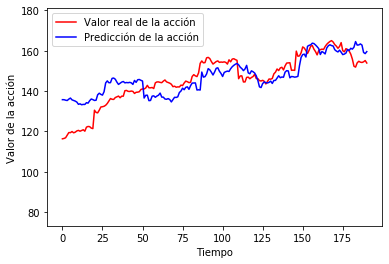

In [283]:
graficar_predicciones(set_validacion.values,prediccion)

251


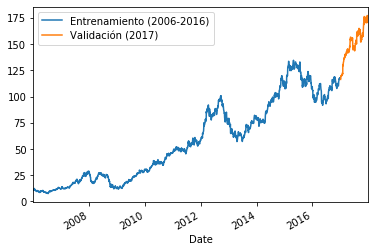

In [284]:
set_entrenamiento['High'].plot(legend=True)
set_validacion['High'].plot(legend=True)
print(set_validacion['High'].size)
plt.legend(['Entrenamiento (2006-2016)', 'Validación (2017)'])
plt.show()

In [285]:

validation_ac=set_validacion.values
accuracy = len([prediccion[i] for i in range(0, len(prediccion)) if prediccion[i] == validation_ac[i]]) / len(prediccion)
print(accuracy)
import sklearn.metrics 
print(set_validacion.values.size)
print(prediccion.size)



0.0
251
191


In [286]:
#print(mean_absolute_error(validation_ac, prediccion))
from sklearn.metrics import mean_absolute_error
mean_absolute_error(validation_ac[:191], prediccion)

5.797864910345428

In [287]:
print(validation_ac)

[[116.33]
 [116.51]
 [116.86]
 [118.16]
 [119.43]
 [119.38]
 [119.93]
 [119.3 ]
 [119.62]
 [120.24]
 [120.5 ]
 [120.09]
 [120.45]
 [120.81]
 [120.1 ]
 [122.1 ]
 [122.44]
 [122.35]
 [121.63]
 [121.39]
 [130.49]
 [129.39]
 [129.19]
 [130.5 ]
 [132.09]
 [132.22]
 [132.44]
 [132.94]
 [133.82]
 [135.09]
 [136.27]
 [135.9 ]
 [135.83]
 [136.75]
 [137.12]
 [137.48]
 [136.66]
 [137.44]
 [137.44]
 [140.15]
 [140.28]
 [139.83]
 [139.77]
 [139.98]
 [139.8 ]
 [138.79]
 [139.36]
 [139.43]
 [139.65]
 [140.75]
 [141.02]
 [141.  ]
 [141.5 ]
 [142.8 ]
 [141.6 ]
 [141.58]
 [141.74]
 [141.22]
 [144.04]
 [144.49]
 [144.5 ]
 [144.27]
 [144.12]
 [144.89]
 [145.46]
 [144.52]
 [144.18]
 [143.88]
 [143.35]
 [142.15]
 [142.38]
 [141.88]
 [142.04]
 [142.  ]
 [142.92]
 [142.68]
 [143.95]
 [144.9 ]
 [144.6 ]
 [144.16]
 [144.3 ]
 [147.2 ]
 [148.09]
 [147.49]
 [147.14]
 [148.98]
 [153.7 ]
 [154.88]
 [153.94]
 [154.07]
 [156.42]
 [156.65]
 [156.06]
 [154.57]
 [153.34]
 [153.98]
 [154.58]
 [154.9 ]
 [154.17]
 [154.35]


In [288]:
print(prediccion)

[[135.7048 ]
 [135.69931]
 [135.45317]
 [135.29149]
 [135.99178]
 [136.50304]
 [135.61414]
 [135.29315]
 [135.00662]
 [134.51906]
 [133.41483]
 [133.64864]
 [133.19783]
 [133.3716 ]
 [133.34737]
 [134.21692]
 [133.99318]
 [135.1785 ]
 [136.0429 ]
 [135.74678]
 [135.32178]
 [135.43648]
 [138.12056]
 [138.9075 ]
 [138.32352]
 [137.96689]
 [139.64838]
 [143.99522]
 [145.00629]
 [144.08066]
 [144.14572]
 [146.26764]
 [146.41159]
 [145.83368]
 [144.41762]
 [143.26653]
 [143.86037]
 [144.41078]
 [144.71204]
 [144.03296]
 [144.20784]
 [144.09937]
 [144.28214]
 [144.03952]
 [143.26636]
 [145.24544]
 [144.28915]
 [145.57538]
 [145.69801]
 [145.28825]
 [144.95615]
 [136.52267]
 [137.87874]
 [137.92897]
 [135.2209 ]
 [135.32089]
 [137.44998]
 [137.60696]
 [136.89845]
 [137.49939]
 [137.9273 ]
 [138.97252]
 [136.9897 ]
 [136.9599 ]
 [136.0416 ]
 [135.90724]
 [136.23611]
 [135.77577]
 [134.59532]
 [135.77785]
 [136.89482]
 [136.8047 ]
 [137.10844]
 [139.23924]
 [139.98212]
 [141.41342]
 [140.64264]